 **We remind that $p(\bar x_{j+1}\vert x_{j+1})$ can be writen as $Z^{-1}(x_{j+1})e^{-\bar E(\bar x_{j+1} \vert x_{j+1}) }$. A model $F(x_{j+1}) = \text{log} (Z(x_{j+1}))$ is learned in this notebook.**

# Import Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import sys
import pickle
#Importing the package
path = '/content/drive/MyDrive/Colab Notebooks/'
sys.path.append(os.path.abspath(path+'WCRG'))
sys.path.append(os.path.abspath(path+'WCRG/WCRG'))
sys.path.append(os.path.abspath(path+'WCRG/Wavelet_Packets'))
sys.path.append(os.path.abspath(path+'WCRG/WCRG/Models'))
#Wavelets
from Wavelet_Packets import *
#Ansatz
from WCRG import *


In [3]:
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from matplotlib import rcParams

# Add every font at the specified location
font_dir = ['/content/drive/MyDrive/cmu']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
# Set font family globally
rcParams['font.family'] = 'CMU serif'
mpl.rcParams.update({# Use mathtext, not LaTeX
                            'text.usetex': False,
                            # Use the Computer modern font
                            'font.family': 'CMU serif',
                            'font.serif': 'cmr10',
                            'mathtext.fontset': 'cm',
                            # Use ASCII minus
                            'axes.unicode_minus': False,
                            })

In [5]:
label_size = 25
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

# Import Data and Define wavelet

In [10]:
#directories for models and synthesis
dir_synth = 'content/drive/MyDrive/Colab Notebooks/WCRG/Notebooks Examples/Synths/'
dir_mod = '/content/drive/MyDrive/Colab Notebooks/WCRG/Notebooks Examples/Models/'
#This key will be add to file name for synthesis and loading
KEY = '128_phi4_0.68'
KEY_Free = KEY +'_Free_'
#Import data
device='cuda' #could be 'cpu' as well
Data = torch.tensor(np.load('/content/drive/MyDrive/Colab Notebooks/Phi4/phi4_L128_Beta0.68.npy')).to(device).to(torch.float32)
print(Data.mean(),Data.std())
#Normalising Data
Data= (Data - Data.mean())/Data.std()
print(Data.shape)
#Computing the number of scales
J=int(np.log2(Data.shape[-1])) #Images of size 2**J
print('J = '+str(J))

tensor(0.0266, device='cuda:0') tensor(0.9076, device='cuda:0')
torch.Size([10000, 128, 128])
J = 7


In [7]:
#Wavelet
m=4
W=Db_wavelets(m,device='cuda',mode='Periodic') #Debauchies 4

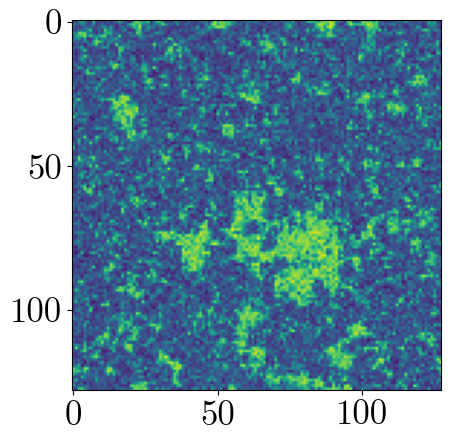

tensor(-0.4312, device='cuda:0')


In [8]:
plt.imshow(Data[0].cpu())
plt.show()
print(Data[1].mean())

# 128

We load the data $x_j$ for $j=0$

depth = 0


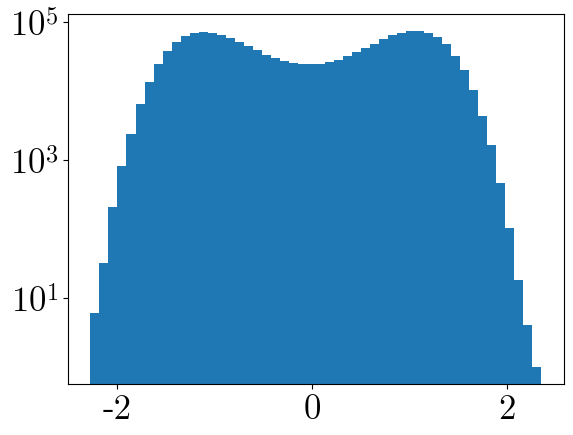

In [11]:
L=128
depth = J-int(np.log2(L))
print('depth = '+str(depth))
phi_s = load_data(W,Data,depth,J,show_hist=False)
plt.hist(phi_s[::100].reshape(-1).cpu(),bins=50)
plt.yscale('log')
plt.show()

Loading $\bar E (x_{j+1}\vert x_{j+1})$

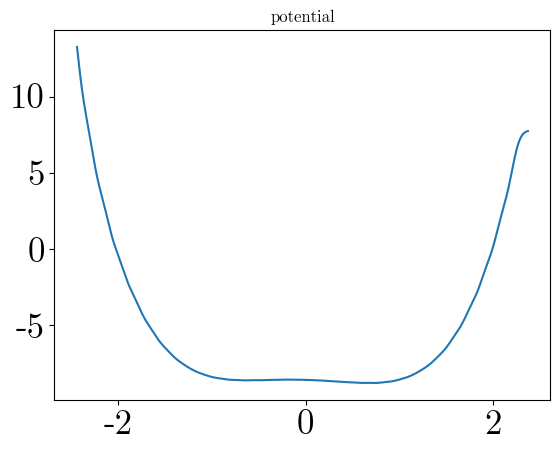

In [15]:
ansatz = load_ansatz(L,KEY,dir_mod)
Show_Sigmoid(ansatz)

Importing $x_{j+1}$ data

depth = 1


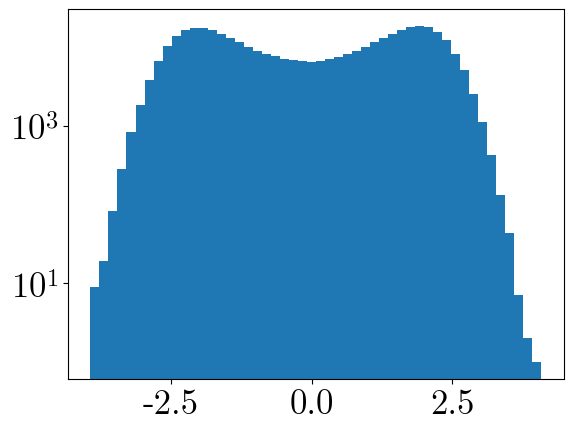

In [16]:
#Phi_wav, for free energy
depth = J-int(np.log2(L//2))
print('depth = '+str(depth))
phi_wav = load_data(W,Data,depth,J,show_hist=False)
plt.hist(phi_wav[::100].reshape(-1).cpu(),bins=50)
plt.yscale('log')
plt.show()

Defining the model for $F(x_{j+1})$

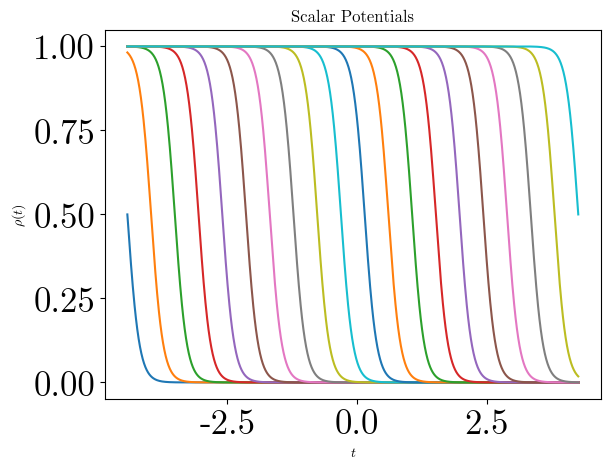

In [17]:
#Scalar Potentials Positioning
window_min,window_max = phi_wav.min(),phi_wav.max()
num_potentials = 20
centers,sigma = linspace_centers(window_min,window_max,num_potentials,extent =0.5*0.5,device='cuda')
#Visualize
Plot_Sigmoid(centers,sigma)
#Shifts
shifts = shifts_quad(8,8)
mode = 'All'
#Ansatz
Free_ansatz =FREE_ANSATZ(W,L,centers,sigma,shifts,shifts_sym = False)

/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacrev')
/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


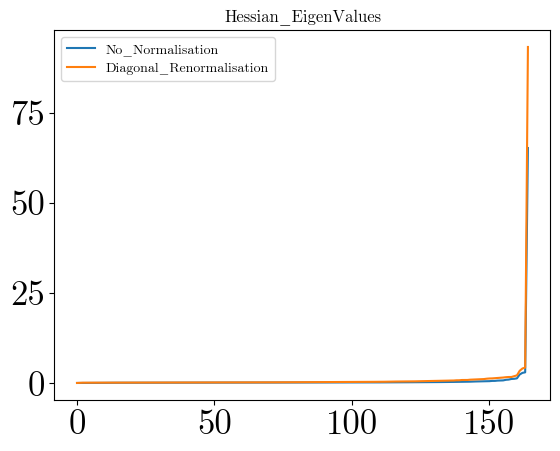

No_Normalisation_Conditioning = tensor(1.9002e+10)
Diagonal_Renormalisation_Conditioning = tensor(15331.9844)


In [18]:
dataloader = torch.utils.data.DataLoader(phi_s[::100], batch_size=5)
Free_estimate(dataloader,Free_ansatz,ansatz)

Visualisation of $\tilde V(x_{j+1})$

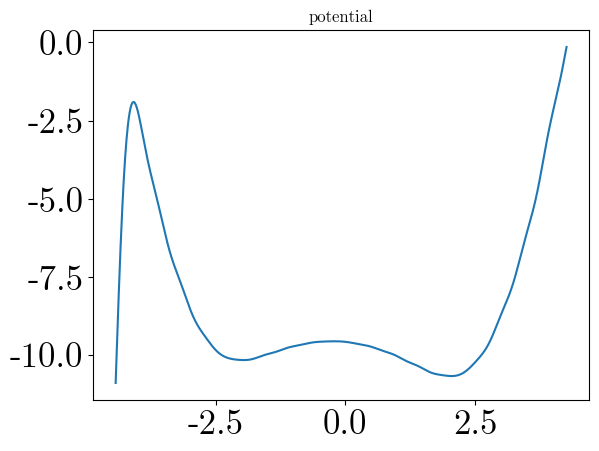

In [19]:
Show_Sigmoid(Free_ansatz,Free=True)